In [1]:
from xy import xy

In [2]:
from shapely.geometry import Point

In [3]:
import sys

In [4]:
sys.path.append('..')

In [5]:
from nbhd import data

In [6]:
db = data.Base()

Initializing database connection...
Database connected!


In [7]:
geom = db.intersects('tiles2', Point(xy))

<AxesSubplot:>

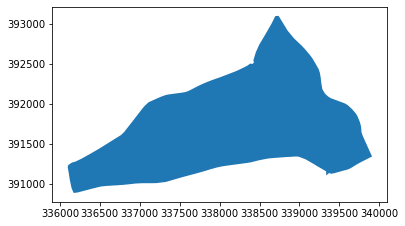

In [8]:
geom.plot()

In [9]:
from nbhd.geometry import pointbox

In [10]:
bounds = geom.bounds.iloc[0]

In [11]:
from shapely.geometry import Polygon

In [12]:
bounds

minx    336097.29
miny    390882.94
maxx    339909.39
maxy    393101.26
Name: 0, dtype: float64

In [13]:
bounds_box = Polygon([(bounds.minx, bounds.miny), (bounds.minx, bounds.maxy),
                     (bounds.maxx, bounds.maxy), (bounds.maxx, bounds.miny), (bounds.minx, bounds.miny)])

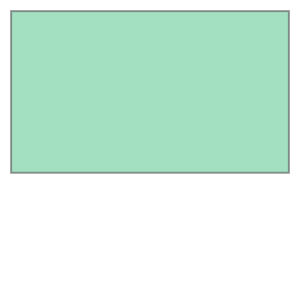

In [14]:
bounds_box

In [15]:
roads = db.intersects('roads', bounds_box.buffer(100))

<AxesSubplot:>

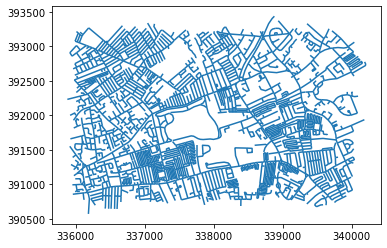

In [16]:
roads.plot()

In [17]:
from nbhd.geometry import trim

In [18]:
trimmed = roads.geometry.apply(lambda x: trim(x, bounds_box.buffer(100)))

<AxesSubplot:>

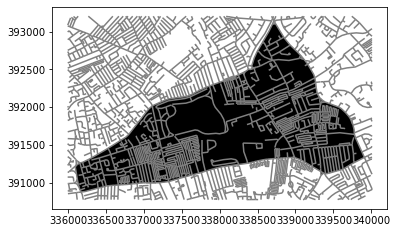

In [19]:
ax = trimmed.plot(color='grey')
geom.plot(ax=ax, color='k')

In [20]:
from nbhd.geography import get_communities

In [21]:
chosen_geometry = geom.geometry[0]
chosen_geometry = bounds_box

In [22]:
df, subgraphs = get_communities(db, chosen_geometry, min_community_size=12)

Starting to find neighbourhoods in polygon centred at POINT (338003.34 391992.1)
Collected 37546 properties...
... of which 34333 are in buildings
Getting streets...
Snapping nodes...
Finding connected graphs...
Labelling communities.


In [23]:
import geopandas as gpd

In [24]:
roads = gpd.GeoDataFrame(df[['roads_id','community']], 
                         geometry=gpd.GeoSeries.from_wkb(df.roads_geometry))

In [25]:
roads = roads.loc[~roads.roads_id.duplicated()]

roads['geometry'] = roads.geometry.apply(lambda x: trim(x, bounds_box))

<AxesSubplot:>

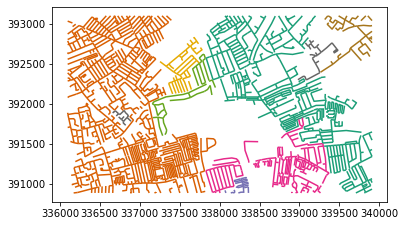

In [26]:
roads.plot('community',cmap='Dark2')

In [27]:
buildings = gpd.GeoDataFrame(df[['buildings_id','community']],geometry=gpd.GeoSeries.from_wkb(df.buildings_geometry))

In [28]:
buildings = buildings.loc[~buildings.buildings_id.duplicated()]

buildings.geometry = buildings.geometry.apply(lambda x: trim(x, bounds_box))

In [29]:
properties = gpd.GeoDataFrame(df[['properties_id','community']],
                             geometry=gpd.GeoSeries.from_wkb(df.properties_geometry))

In [30]:
import matplotlib.pyplot as plt

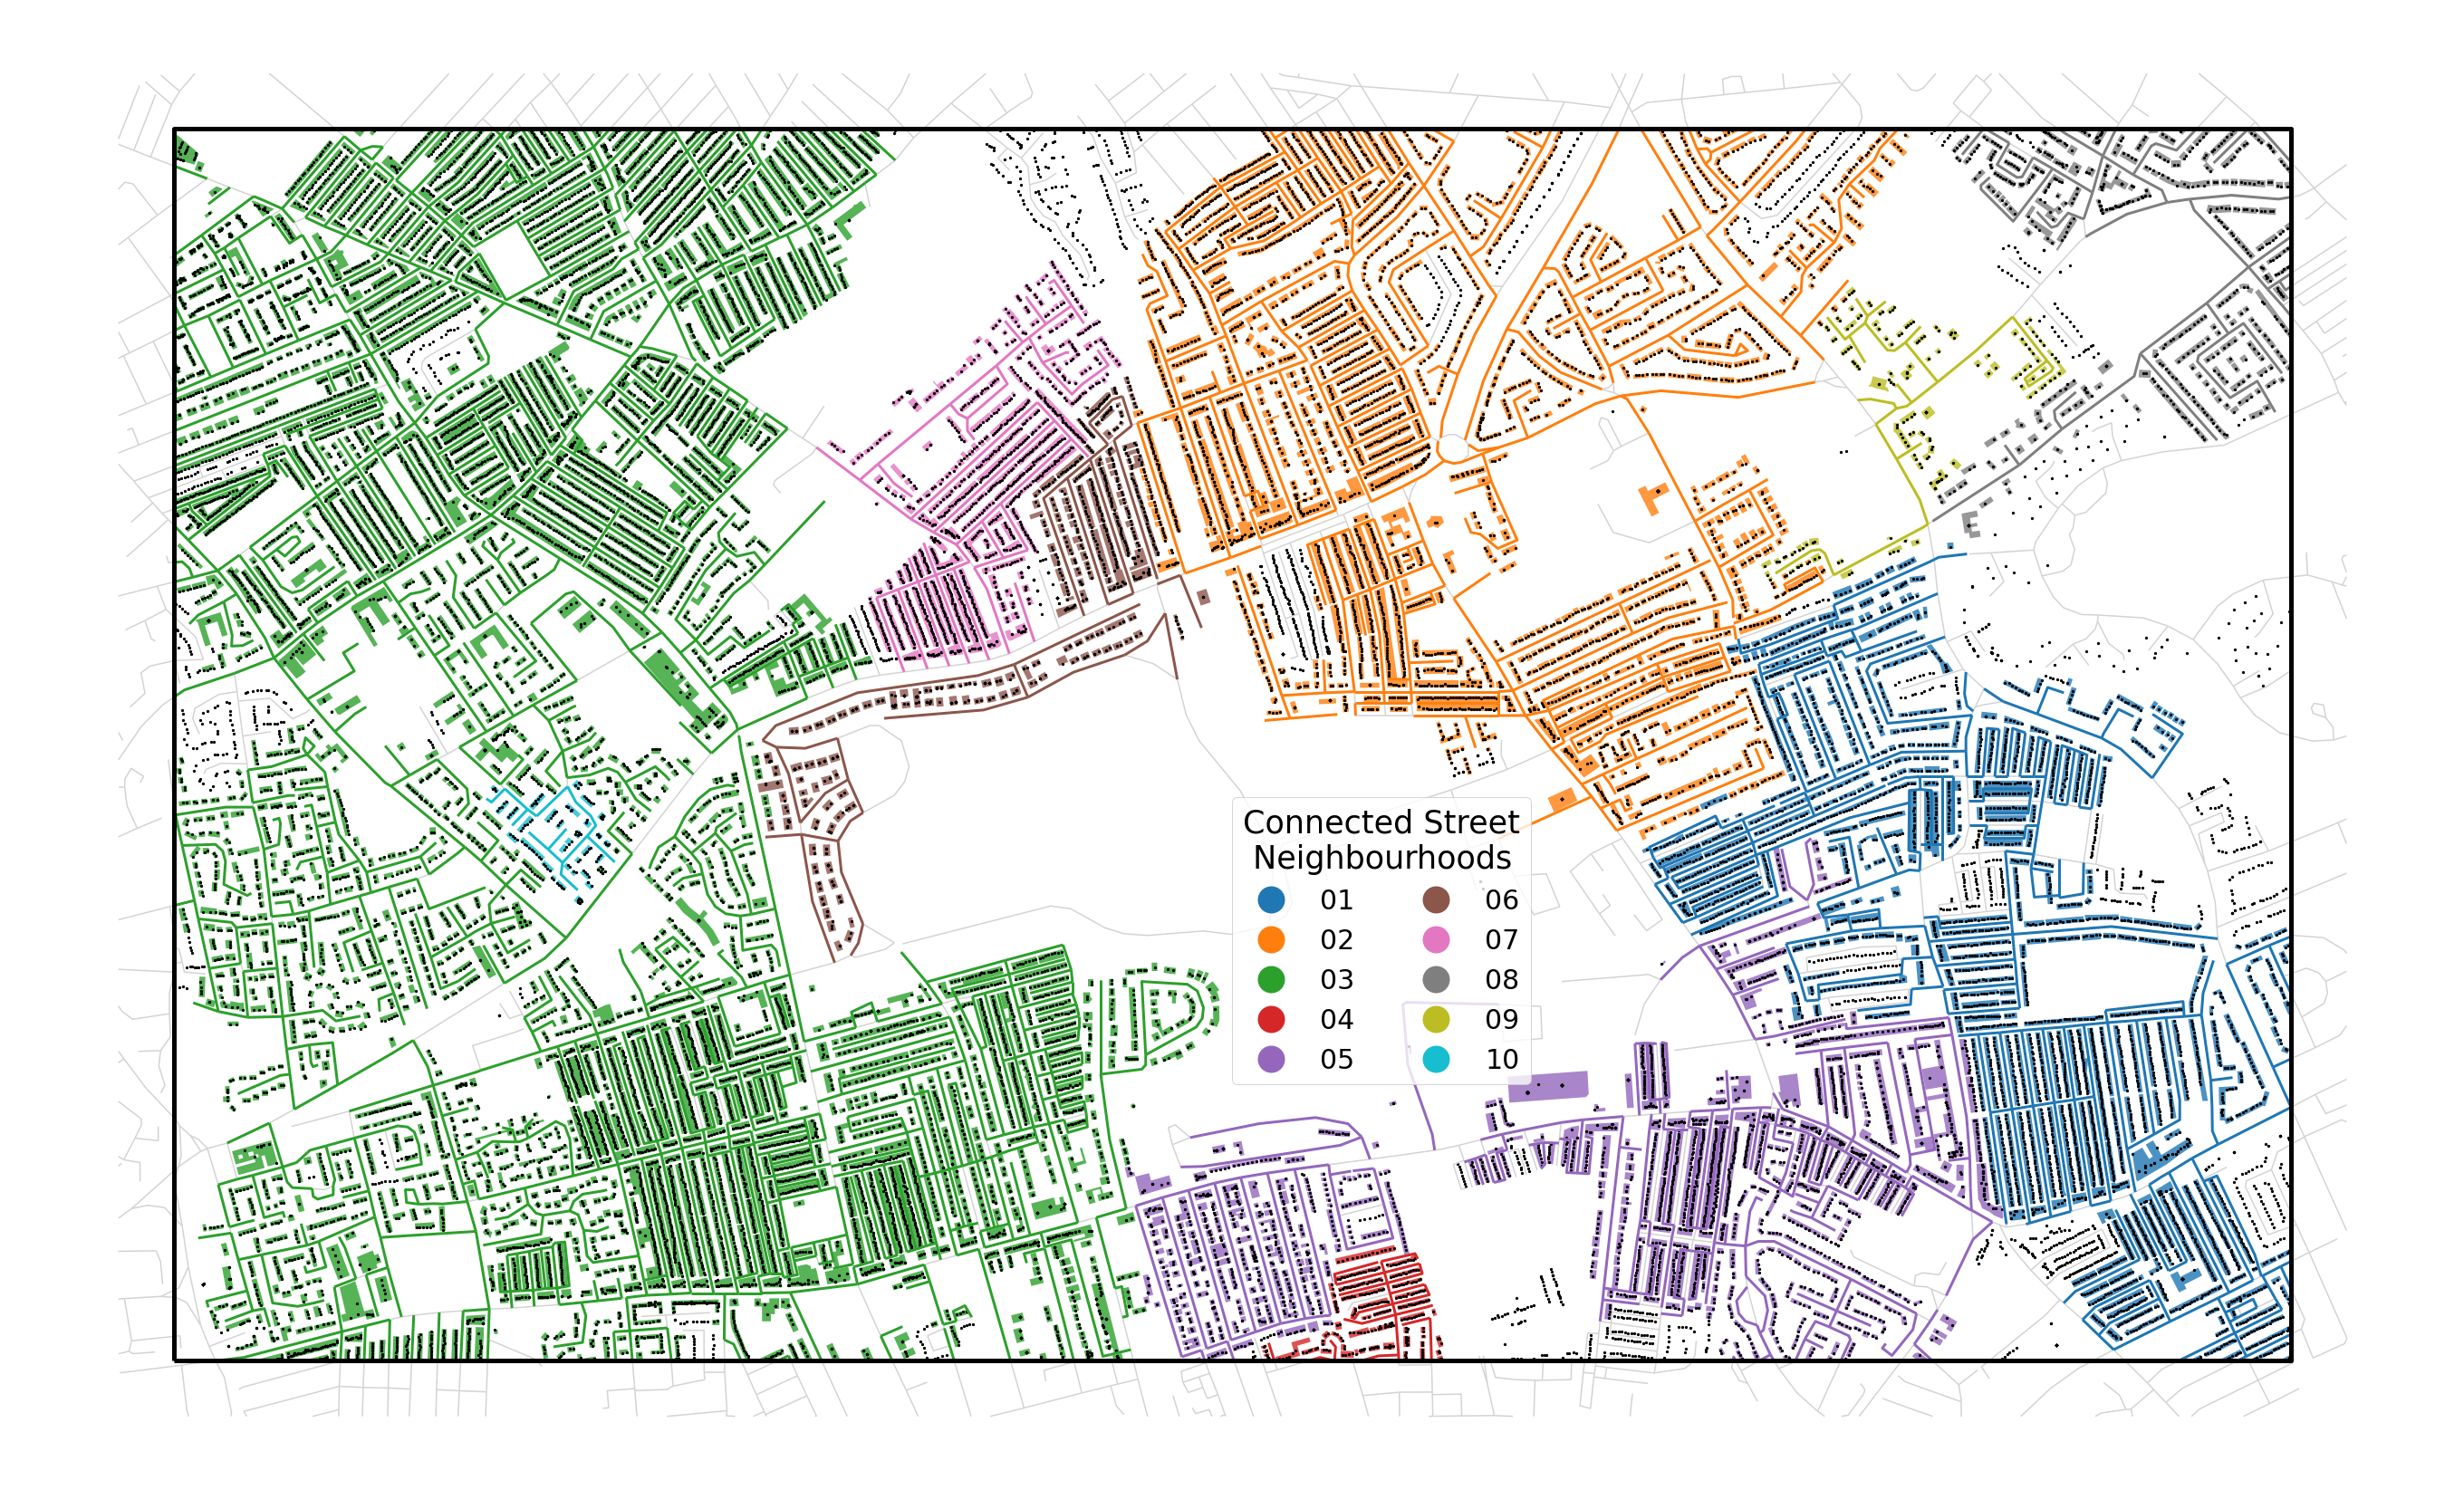

In [31]:
cmap='tab10'
fig, ax = plt.subplots(figsize=(60,30))
trimmed.plot(color='lightgrey', ax=ax)
buildings.plot('community', alpha=0.8, ax=ax, cmap=cmap)
roads.plot('community', ax=ax, linewidth=3, cmap=cmap, legend=True, 
           legend_kwds={'fontsize':30, 
                        'markerscale':3,
                        'loc':(0.5,0.27),#'best',
                        'title': 'Connected Street\n Neighbourhoods',
                        'title_fontsize':35,
                        'markerfirst': True,
                        'ncol':2})
properties.plot(color='k', ax=ax, markersize=5)
gpd.GeoSeries(bounds_box).boundary.plot(color='k', linewidth=5, ax=ax)
ax.set_axis_off()

In [36]:
ax.figure.savefig('connected_nbhd.png',
                  bbox_inches='tight',
                 transparent=False, pad_inches=0)